In [39]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import random
import json
from music21 import pitch

from ndbc_api import NdbcApi

api = NdbcApi()

In [40]:
def load_buoy_data(filename):
    with pd.HDFStore(filename) as store:
        availability_df = store['availability']
        station_data = {}
        for key in store.keys():
            if key.startswith('/station_'):
                station = key.split('_', 1)[1]
                station_data[station] = store[key]
    
    return station_data, availability_df

def filter_by_ocean(availability_df, cleaned_station_data, buoys_df, ocean_name):
    # Filter buoys_df to get stations from the specified ocean
    ocean_stations = buoys_df[buoys_df['Ocean'] == ocean_name]['Station'].tolist()

    # Filter availability_df
    filtered_availability = availability_df.loc[availability_df.index.intersection(ocean_stations)]
    
    # Remove columns filled with zero
    filtered_availability = filtered_availability.loc[:, (filtered_availability != 0).any(axis=0)]

    # Filter cleaned_station_data
    filtered_station_data = {station: data for station, data in cleaned_station_data.items() if station in ocean_stations}

    return filtered_availability, filtered_station_data

def create_music_base_dict(ocean_dict, variable_ranges, availability, output_octaves):
    ocean_music_base_dict = {}

    for station in availability.index:
        if station not in ocean_dict:
            continue

        df = ocean_dict[station]
        # Create a copy of the original dataframe, but only with columns that exist in both df and availability
        available_columns = [col for col in availability.columns if col in df.columns]
        normalized_df = df[available_columns].copy()

        for variable in available_columns:
            if availability.loc[station, variable] == 1:
                if variable not in variable_ranges:
                    print(f"Warning: {variable} not found in variable_ranges. Skipping.")
                    continue

                min_val, max_val = variable_ranges[variable]
                
                # Normalize the data
                normalized_df[variable] = (df[variable] - min_val) / (max_val - min_val)
                
                # Scale to the desired number of octaves
                normalized_df[variable] = normalized_df[variable] * (output_octaves * 7)
                
                # Round to nearest integer, but keep NaN values
                normalized_df[variable] = normalized_df[variable].apply(lambda x: round(x) if pd.notnull(x) else x)

        ocean_music_base_dict[station] = normalized_df

    return ocean_music_base_dict



def plot_music_base_dict(ocean_music_base_dict):
    # Determine the number of stations
    n_stations = len(ocean_music_base_dict)
    
    # Calculate the grid dimensions
    n_cols = 3  # You can adjust this for a different layout
    n_rows = (n_stations - 1) // n_cols + 1

    # Create a new figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    fig.suptitle("Normalized and Scaled Data for All Stations", fontsize=16)

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    for i, (station, df) in enumerate(ocean_music_base_dict.items()):
        ax = axes[i]
        
        # Plot each variable
        for column in df.columns:
            ax.plot(df.index, df[column], label=column)
        
        ax.set_title(f"Station: {station}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Scaled Value")
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.grid(True)

        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    
# Define the intervals for each mode
modes = {
        'Ionian': [0, 2, 4, 5, 7, 9, 11],
        'Dorian': [0, 2, 3, 5, 7, 9, 10],
        'Phrygian': [0, 1, 3, 5, 7, 8, 10],
        'Lydian': [0, 2, 4, 6, 7, 9, 11],
        'Mixolydian': [0, 2, 4, 5, 7, 9, 10],
        'Aeolian': [0, 2, 3, 5, 7, 8, 10],
        'Locrian': [0, 1, 3, 5, 6, 8, 10]
    }

def get_midi_notes(mode='Ionian', midi_base=60, octaves=2):
    # Get the intervals for the specified mode
    intervals = modes.get(mode)
    
    if intervals is None:
        raise ValueError(f"Mode '{mode}' is not recognized.")
    # Create note mapping based on the input key and octave
    notes_midi = []
    for octave in range(octaves):
        notes_midi.extend([midi_base + interval + (octave * 12) for interval in intervals])

    return notes_midi

# Function to map a DataFrame column to MIDI notes
def map_to_midi(df_column, mode='Ionian', midi_base=0, octaves=2):
    midi_notes = get_midi_notes(mode, midi_base, octaves)
    # Map values from 0 to (7*octaves-1) to MIDI notes, casting to int
    midi_mapped = df_column.apply(lambda x: midi_notes[int(x)] if 0 <= x < 7*octaves and not pd.isna(x) else None)
    return midi_mapped

def create_midi_progression(music_base_dict, channel_data, main_key, mode, octaves=5):
    # Load instrument data
    with open('../MainApi and assets/instrumentos_all.json', 'r', encoding='utf-8') as f:
        instruments = json.load(f)
    
    # Convert main_key to MIDI base note
    main_key_midi = pitch.Pitch(main_key).midi
    print(main_key_midi)
    
    # Initialize output list
    output_list = []
    
    # Process each channel
    for channel in channel_data:
        buoy = channel['buoy']
        print(buoy)
        variable = channel['variable']
        instrument_name = channel['instrument']
        
        # Get instrument data
        instrument = next((i for i in instruments if i['name'] == instrument_name), None)
        if not instrument:
            raise ValueError(f"Instrument {instrument_name} not found")
        
        # Find appropriate MIDI base
        low_midi = instrument['low_midi']
        high_midi = instrument['high_midi']
        
        # Calculate the first note in the instrument range that matches the main key
        midi_base = low_midi
        while midi_base % 12 != main_key_midi % 12:
            midi_base += 1
        
        # If the calculated midi_base is higher than the instrument's high_midi,
        # start from low_midi and go up by octaves until we're in range
        if midi_base > high_midi:
            midi_base = low_midi
            while midi_base % 12 != main_key_midi % 12:
                midi_base += 12
        
        # Ensure we have enough range for the specified number of octaves
        required_range = octaves * 12
        while midi_base + required_range > high_midi:
            midi_base -= 12
        
        # If we've gone below the low_midi, raise an error
        if midi_base < low_midi:
            print(f"Cannot fit {octaves} octaves within the instrument range")
        
        print(f"instrument:{instrument['name']}\nlow_midi:{low_midi}\nhigh_midi:{high_midi}\nmidi_base:{midi_base}\n")
        
        # Get data from the music_base_dict
        if buoy not in music_base_dict or variable not in music_base_dict[buoy].columns:
            raise ValueError(f"Data for buoy {buoy} and variable {variable} not found")
        
        data = music_base_dict[buoy][variable]
        
        print(data)
        
        # Map data to MIDI notes
        midi_mapped = map_to_midi(data, mode=mode, midi_base=midi_base, octaves=octaves)
         
        print(midi_mapped)
        
        # Create DataFrame for this channel
        df = pd.DataFrame({f"{instrument_name}_{variable}": midi_mapped})
    
        # Fill NaN values with None
        df = df.where(pd.notnull(df), None)
    
        # Add DataFrame to output list
        output_list.append(df)
    
    return output_list

def play_midi_progression(progression, tempo, outport):
    # Calculate delay based on tempo (beats per minute)
    delay = 60 / tempo  # seconds per beat

    # Initialize dictionaries to keep track of currently playing notes for each channel
    current_notes = {}

    # Determine the length of the progression
    max_length = max(len(df) for df in progression)

    for i in range(max_length):
        for channel, df in enumerate(progression):
            if i < len(df):
                column_name = df.columns[0]  # Get the name of the only column
                note = df.iloc[i][column_name]
                
                if pd.notna(note) and not np.isnan(note):
                    try:
                        note = int(note)
                    
                        # If there's a currently playing note for this channel and it's different
                        if channel in current_notes and current_notes[channel] != note:
                            # Send note off for the previous note
                            msg_off = mido.Message('note_off', note=current_notes[channel], velocity=64, channel=channel)
                            outport.send(msg_off)
                        
                        # If it's a new note or a different note from the previous one
                        if channel not in current_notes or current_notes[channel] != note:
                            # Send note on for the new note
                            msg_on = mido.Message('note_on', note=note, velocity=64, channel=channel)
                            outport.send(msg_on)
                            current_notes[channel] = note
                    except ValueError:
                        # If the note can't be converted to an integer, ignore it
                        pass
                
                elif channel in current_notes:
                    # If there's no valid note and there was a note playing, stop it
                    msg_off = mido.Message('note_off', note=current_notes[channel], velocity=64, channel=channel)
                    outport.send(msg_off)
                    del current_notes[channel]

        # Wait for the duration of one beat
        time.sleep(delay)

    # After the progression ends, turn off any remaining notes
    for channel, note in current_notes.items():
        msg_off = mido.Message('note_off', note=note, velocity=64, channel=channel)
        outport.send(msg_off)
    
    
    

def create_random_channel_data(n, filtered_availability, instruments):
    channel_data = []
    
    # Get unique buoys from filtered_availability index
    buoys = filtered_availability.index.unique()
    
    # Get list of instrument names
    instrument_names = [instrument['name'] for instrument in instruments]
    
    for _ in range(n):
        # Randomly select a buoy
        buoy = random.choice(buoys)
        
        # Get variables available for this buoy
        available_variables = filtered_availability.loc[buoy].index[filtered_availability.loc[buoy] == 1].tolist()
        
        # Randomly select a variable
        variable = random.choice(available_variables)
        
        # Randomly select an instrument
        instrument = random.choice(instrument_names)
        
        # Create channel data entry
        channel = {
            "buoy": buoy,
            "variable": variable,
            "instrument": instrument
        }
        
        channel_data.append(channel)
    
    return channel_data

In [3]:
# ReRading the df
buoy_df = pd.read_csv('buoys_with_ocean.csv')
buoy_df.head()

,Station,Lat,Lon,Elevation,Name,Owner,Program,Ocean
0,13001,12.0,-23.0,0.0,NE Extension,Prediction and Research Moored Array in the At...,International Partners,Atlantic Ocean
1,13002,21.0,-23.0,0.0,NE Extension,Prediction and Research Moored Array in the At...,International Partners,Atlantic Ocean
2,13008,15.0,-38.0,0.0,Reggae,Prediction and Research Moored Array in the At...,International Partners,Atlantic Ocean
3,13009,8.0,-38.0,0.0,Lambada,Prediction and Research Moored Array in the At...,International Partners,Atlantic Ocean
4,14048,-8.0,65.0,0.0,NaN,Research Moored Array for African-Asian-Austra...,International Partners,Indian Ocean


In [4]:
# Loading data
station_data, availability_df = load_buoy_data('buoy_data_20240601_to_20240916.h5')


In [5]:
# Example usage:
filtered_availability, filtered_station_data = filter_by_ocean(availability_df, station_data, buoy_df, "Indian Ocean")


In [6]:
filtered_availability

,WDIR,WSPD,GST,PRES,ATMP,WTMP
14048,0,0,0,0,0,1
14049,1,1,1,1,1,1
23001,1,1,0,1,1,1
23003,1,1,0,0,1,1
23012,1,1,0,0,1,1
23013,1,1,0,0,1,1
23014,1,1,0,0,1,1
23015,1,1,0,0,1,1
23016,1,1,0,0,1,1
23019,1,1,1,0,1,1


In [7]:
variable_ranges = {
    'WDIR': (0, 360),       # Wind direction in degrees
    'WSPD': (0, 14),        # Wind speed in m/s (adjust max as needed)
    'GST': (2, 16),         # Wind gust speed in m/s (adjust max as needed)
    'PRES': (1006, 1018),   # Atmospheric pressure in hPa
    'ATMP': (24, 30),       # Air temperature in °C
    'WTMP': (26, 31)        # Water temperature in °C
}

output_octaves = 3

# Usage
indian_ocean_music_base_dict = create_music_base_dict(filtered_station_data, variable_ranges, filtered_availability, output_octaves)

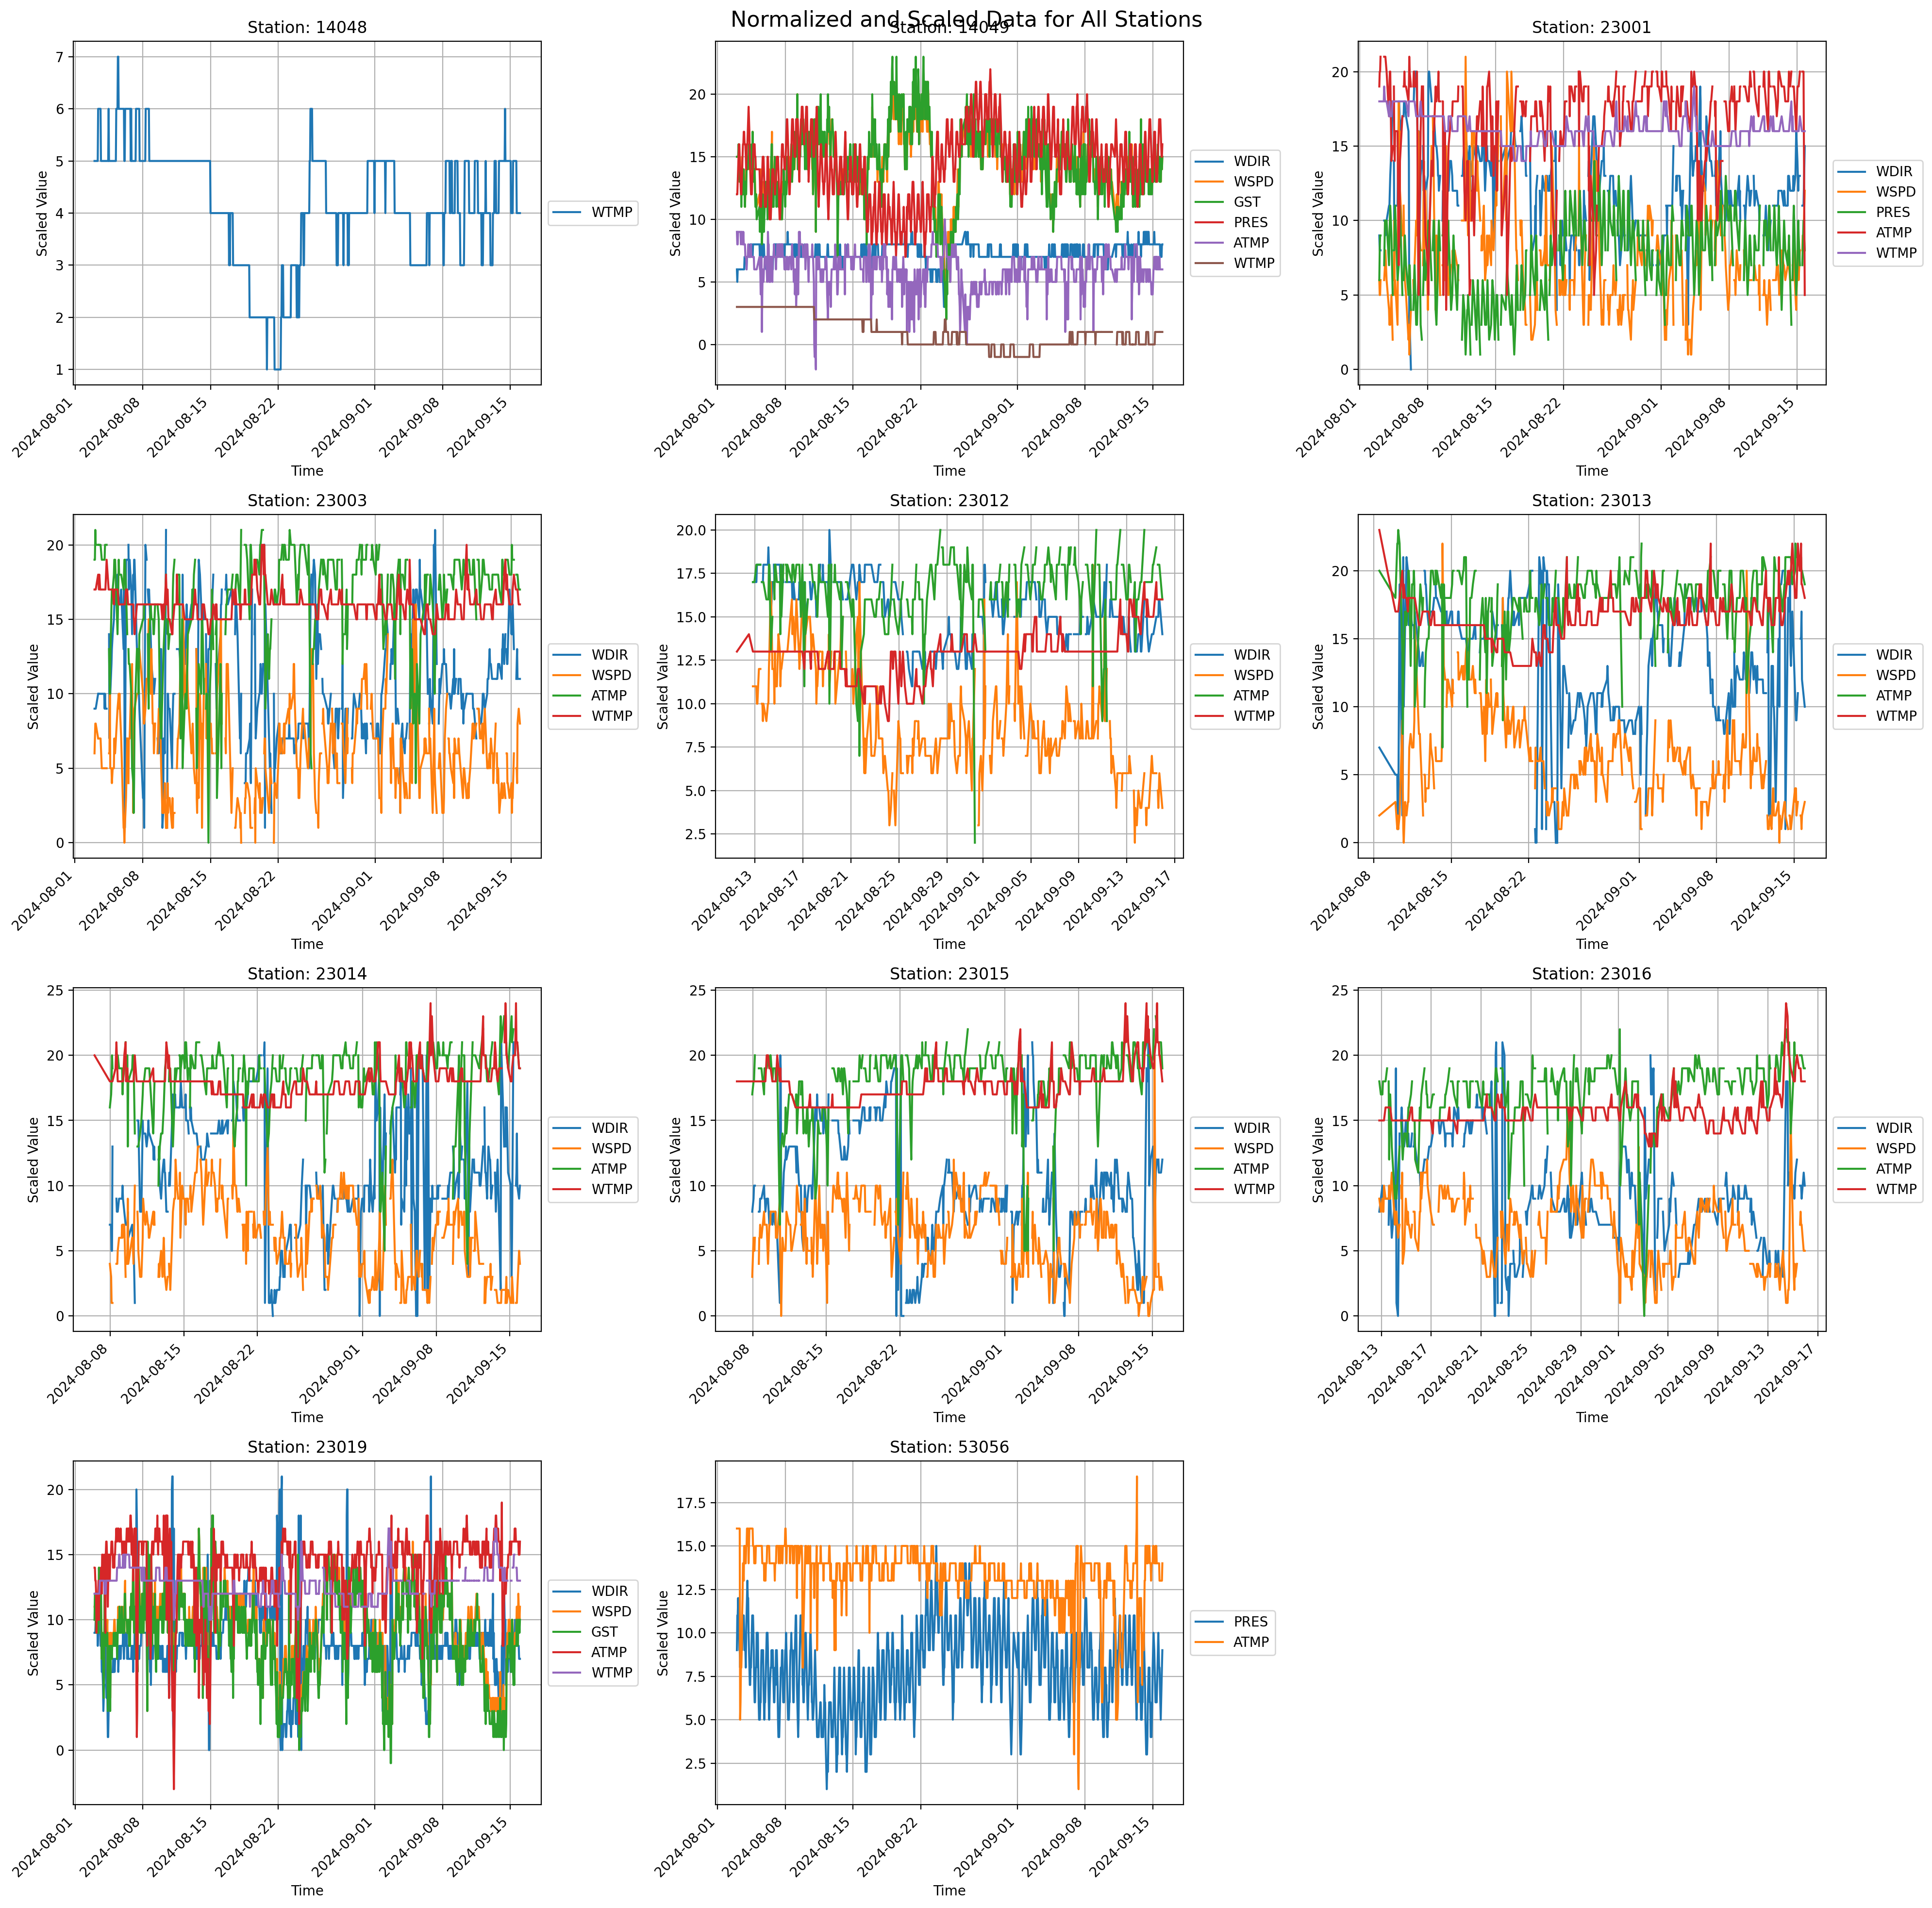

In [8]:
# Usage
plot_music_base_dict(indian_ocean_music_base_dict)

In [34]:
tempo = 250
main_key = "C"
mode = "Mixolydian"

channel_data = [
    {
        "buoy": "53056",
        "variable": "PRES",
        "instrument": "Piano",
    },
    {
        "buoy": "23014",
        "variable": "WTMP",
        "instrument": "Contrabajo"
    },
    {
        "buoy": "14049",
        "variable": "PRES",
        "instrument": "Flautín"
    },
    {
        "buoy": "14049",
        "variable": "PRES",
        "instrument": "Flautín"
    }
]

In [36]:
import json

# Load the instruments data
with open('../MainAPI and assets/instrumentos_all.json', 'r') as f:
    instruments = json.load(f)

# Assuming you have already created the filtered_availability dataframe
n_channels = 5  # or any number of channels you want

channel_data = create_random_channel_data(n_channels, filtered_availability, instruments)

# Print the result
channel_data

[{'buoy': '23001', 'variable': 'WTMP', 'instrument': 'Glockenspiel'},
 {'buoy': '14048', 'variable': 'WTMP', 'instrument': 'Xylophone'},
 {'buoy': '14048', 'variable': 'WTMP', 'instrument': 'Marimba'},
 {'buoy': '23013', 'variable': 'WDIR', 'instrument': 'Piccolo'},
 {'buoy': '23019', 'variable': 'WTMP', 'instrument': 'Viola'}]

In [10]:
import mido
import time

print("Output ports:", mido.get_output_names())
print("Input ports:", mido.get_input_names())

Output ports: ['Microsoft GS Wavetable Synth 0', 'MPKmini2 1', 'Python2Reaper 2', 'IAC Driver Bus 1 3']
Input ports: ['MPKmini2 0', 'Python2Reaper 1', 'IAC Driver Bus 1 2']


In [11]:

# Define the MIDI port (you may need to adjust this)
port_name = 'IAC Driver Bus 1 3'
outport = mido.open_output(port_name)  # Replace with your MIDI output port name


In [45]:


result = create_midi_progression(indian_ocean_music_base_dict, channel_data, main_key, mode)
# Assuming 'result' is an array of dataframes
limited_result = [df.iloc[:100] for df in result]
play_midi_progression(limited_result, tempo, outport)


60
23001
Cannot fit 5 octaves within the instrument range
instrument:Glockenspiel
low_midi:77
high_midi:108
midi_base:48

timestamp
2024-08-03 01:00:00    18
2024-08-03 02:00:00    18
2024-08-03 03:00:00    18
2024-08-03 04:00:00    18
2024-08-03 12:00:00    18
                       ..
2024-09-15 13:00:00    16
2024-09-15 14:00:00    16
2024-09-15 15:00:00    16
2024-09-15 16:00:00    16
2024-09-15 19:00:00    16
Name: WTMP, Length: 474, dtype: int64
timestamp
2024-08-03 01:00:00    79
2024-08-03 02:00:00    79
2024-08-03 03:00:00    79
2024-08-03 04:00:00    79
2024-08-03 12:00:00    79
                       ..
2024-09-15 13:00:00    76
2024-09-15 14:00:00    76
2024-09-15 15:00:00    76
2024-09-15 16:00:00    76
2024-09-15 19:00:00    76
Name: WTMP, Length: 474, dtype: int64
14048
Cannot fit 5 octaves within the instrument range
instrument:Xylophone
low_midi:65
high_midi:108
midi_base:48

timestamp
2024-08-03 00:00:00    5
2024-08-03 01:00:00    5
2024-08-03 02:00:00    5
2024-08-0